# Get Bi-Annual Pedestrian Counts from NYC

We are going to use the New York City pedestrian count data to verify the feasibility of using CNN for measuring pedestrian volume. For NYC pedestrian data see below:

> An index of pedestrian volumes tracking the long-term trends of neighborhood commercial corridors. Data is collected at 114 locations, including 100 on-street locations (primarily retail corridors), 13 East River and Harlem River bridge locations, and the Hudson River Greenway. Screenline sampling is conducted during May and September on the sidewalk, mid-block (or mid-bridge) on both sides of street where applicable. Pedestrian volumes at 50 sample locations around the City are combined to create the Pedestrian Volume Index for the Mayor’s Management Report. Click here for metadata - http://www.nyc.gov/html/dot/downloads/pdf/bi-annual-ped-count-readme.pdf

> from https://data.cityofnewyork.us/Transportation/Bi-Annual-Pedestrian-Counts/2de2-6x2h/about


## import libraries

In [1]:
import os
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import geopandas as gpd
import streetscape as ss
from shapely.geometry import Point

import nest_asyncio  # required for jupyter
nest_asyncio.apply()

## get the dataset from NYC open data

In [2]:
query = ("https://data.cityofnewyork.us/resource/cqsj-cfgu.json")
df = pd.read_json(query)
df.head()

,borough,the_geom,objectid,loc,street_nam,from_stree,to_street,index,may_07_am,may_07_pm,...,sept_17_pm,sept_17_md,may_18_am,may_18_pm,may_18_md,sept_18_pm,sept_18_md,may_19_am,may_19_pm,may_19_md
0,Bronx,"{'type': 'Point', 'coordinates': [-73.90459140...",1,1,Broadway,West 231st Street,Naples Terrace,N,1189,4094,...,"4,044","2,731","1,271","4,502","2,899","4,464","2,967",-,-,-
1,Bronx,"{'type': 'Point', 'coordinates': [-73.92188432...",2,2,East 161st Street,Grand Concourse,Sheridan Avenue,Y,1511,3184,...,"5,952","2,832","1,749","5,148","2,156","4,723","1,604","1,702","4,347","1,576"
2,Bronx,"{'type': 'Point', 'coordinates': [-73.89535781...",3,3,East Fordham Road,Valentine Avenue,Tiebout Avenue,Y,1832,12311,...,"12,388","7,076","2,209","9,634","7,066","8,931","6,212","1,625","11,739","7,468"
3,Bronx,"{'type': 'Point', 'coordinates': [-73.87892467...",4,4,East Gun Hill Road,Bainbridge Avenue,Rochambeau Avenue,N,764,2673,...,"3,429","1,551","1,648","2,892","1,323","2,682","1,693",-,-,-
4,Bronx,"{'type': 'Point', 'coordinates': [-73.88956389...",5,5,East Tremont Avenue,Prospect Avenue,Clinton Avenue,N,650,2538,...,"3,330","2,479","1,016","3,781","2,565","3,761","2,461",-,-,-


In [3]:
# total number of locations
len(df['loc'].unique())

114

## Convert to Geographic format
This dataset's geometry is json format. Let's convert this to shapely format to utilize streetscape.

In [4]:
df['geometry']  = df['the_geom'].apply(lambda r: Point(r['coordinates']))
df['pano_id'] = None
df['indexed'] = df['index']
df['index'] = df['loc']

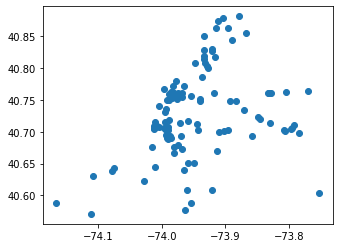

In [10]:
gdf = gpd.GeoDataFrame(df)
gdf.to_file("../data/nyc_location/nyc_location.geojson")
gdf.plot()

## Get street view images
- 18 images per one location (FOV=20) with 2 degree overlap
- 600px X 600px
- saved under ../data/gsv

In [7]:
di = ss.make_gsv_urls(df, npics=18, size=600, pad=2)

Total 2052 urls created.


In [11]:
ss.download_gsvs(di, save_dir='../data/gsv')

## Retrieve Metadata

We want to know when the GSVs are taken.

In [23]:
def metadata_url(obs_point):
        ''' construct a url for retrieving gsv metadata 
        at obs point location'''
        lat = obs_point.geometry.y
        lng = obs_point.geometry.x
        base = "https://maps.googleapis.com/maps/api/streetview/metadata?"
        latlng = "location={},{}".format(lat, lng)
        source = "source=outdoor"
        url = "{}&{}&{}".format(base, latlng, source)
        return url
    
df['metadata_url'] = df.apply(metadata_url, axis=1)

In [25]:
responses = ss.retrieve_metadata(df, 50, 10, 0)

In [31]:
res_df = pd.DataFrame.from_records(responses)
res_df['date'].value_counts().sort_index()

2007-09     1
2014-07     2
2014-08     1
2016-07     1
2016-10     1
2017-05     1
2017-07     1
2017-09     1
2017-11     1
2017-12     4
2018-05     3
2018-06     4
2018-07     6
2018-08     9
2018-09     2
2018-10     3
2019-05     9
2019-06    28
2019-07    16
2019-08    15
2019-09     4
2019-10     1
Name: date, dtype: int64

Mostly taken in 2018 and 2019.